In [1]:
%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import roc_auc_score, confusion_matrix, recall_score, make_scorer, auc, roc_curve

# Import data
bank = pd.read_csv('bank-additional-full.csv', sep=';')

In [2]:
bank.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [2]:
# Define functions for data preprocessing.

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

def One_hot_encoding(dataset, attr):
    
    ''' Perform One Hot Encoding on an attribute of a dataset.
    Arguments:
        -- dataset: the data set.
        -- attr: the attribute name, in string form.
        
    Output:
        return the dataset with added encoded attributes. And the original attribute is dropped'''
        
    ohc = OneHotEncoder()
    ohe = ohc.fit_transform(dataset[attr].values.reshape(-1,1)).toarray()
    dfOneHot = pd.DataFrame(ohe,columns = [attr + '_' + str(ohc.categories_[0][i]) for i in range(len(ohc.categories_[0]))])
    dataset = pd.concat([dataset,dfOneHot], axis=1)
    dataset.drop([attr], axis = 1,inplace=True)
    
    return dataset

def Ordinal_encoding(dataset, attr, category = 'auto'):
    
    ''' Perform One Hot Encoding on an attribute of a dataset.
    Arguments:
        -- dataset: the data set.
        -- attr: the attribute name, in string form.
        -- category: should be a list, with the ith element is encoded as i (integer). default: 'auto'.
        
    Output:
        return the dataset with added encoded attribute. And the original attribute is dropped'''
    enc = OrdinalEncoder(categories = [category])
    dataset[attr + '_encoded'] = enc.fit_transform(dataset[attr].values.reshape(-1,1))
    dataset.drop([attr], axis = 1,inplace=True)
    
    return dataset

def label_encoding(dataset, attr):
    
    ''' Perform Label Encoding on the target attribute of a dataset.
    Arguments:
        -- dataset: the data set.
        -- attr: the target attribute, in string form.
        
    Output:
        return the dataset with encoded target attribute, with the original attribute dropped.'''
        
    le = LabelEncoder()
    dataset[attr + '_encoded'] = le.fit_transform(dataset[attr])
    dataset.drop([attr], axis = 1,inplace=True)
    
    return dataset    

def standardization(dataset, attr):
    
    ''' Scale the numeric attribute of the dataset to zero mean unit variance.
    Arguments:
        -- dataset: the data set.
        -- attr: the attribute name, in string form.
        
    Output:
        return the dataset with standardized attribute. And the original attribute is dropped'''
        
    ss = StandardScaler()
    dataset[attr +'_scaled'] = ss.fit_transform(dataset[attr].values.reshape(-1,1))
    dataset.drop([attr], axis = 1,inplace=True)
    
    return dataset    

Data preprocessing.

1. The target attribute has two values. Encode "no" and "yes" to 0 and 1, respectively.

2. The column "pdays" has too many missing values and is not useable. Drop it.

3. The column "education" is an ordinal attribute. Convert it into integers, with higher values representing higher levels of education.

4. Encode other categorical variables using one-hot encoding and scale to zero mean unit variance.

In [3]:
# encode label
bank = label_encoding(bank, 'y')  

# drop unwanted columns.
bank.drop(['pdays'], axis = 1, inplace=True)

# preprocess ordinal variable: 'education'
bank = Ordinal_encoding(bank, 'education', ['illiterate', 'basic.4y', 'basic.6y', 'basic.9y', 'unknown', 'high.school','professional.course', 'university.degree'])

# encode nominal categorical variables ('job', 'marital',  'default', 'housing', 'loan', 'contact','poutcome')
bank = One_hot_encoding(bank, 'job')
bank = One_hot_encoding(bank, 'marital')
bank = One_hot_encoding(bank, 'default')
bank = One_hot_encoding(bank, 'housing')
bank = One_hot_encoding(bank, 'contact')
bank = One_hot_encoding(bank, 'poutcome')
bank = One_hot_encoding(bank, 'loan')

# encode time variables ('month', 'day_of_week') using One-Hot encoder  
bank = One_hot_encoding(bank, 'month')
bank = One_hot_encoding(bank, 'day_of_week')

# standardize the numerical variables ('duration', 'campaign', 'pdays','previous','emp.var.rate',
# 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed')
bank = standardization(bank, 'age')
bank = standardization(bank, 'duration')
bank = standardization(bank, 'campaign')
bank = standardization(bank, 'previous')
bank = standardization(bank, 'emp.var.rate')
bank = standardization(bank, 'cons.price.idx')
bank = standardization(bank, 'cons.conf.idx')
bank = standardization(bank, 'euribor3m')
bank = standardization(bank, 'nr.employed')
bank = standardization(bank, 'education_encoded')

In [4]:
# Split data set. Test set: 20%. Validation set + training set: 80%

from sklearn.model_selection import train_test_split

y = bank.iloc[:,bank.columns == 'y_encoded'].values.ravel() # convert to 1D, to meet the requirement of fit_transform()
X = bank.iloc[:, bank.columns != 'y_encoded']
        
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size =.20, random_state = 1, stratify = y)

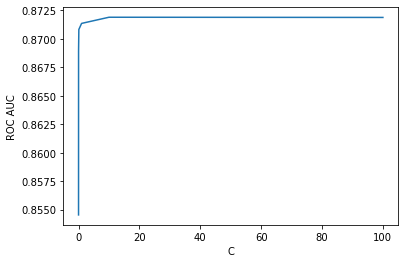

In [5]:
# Tuning parameters.
# In sklearn.linear_model.LogisticRegression, the choices of some parameters (eg. penalty) are dependent on the choice of solver. 
# For simplicity, here only shows the code for hyperparameter search for 'lbfgs' solver.

from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

scoring = make_scorer(roc_auc_score)
Cs = [1e-3, 1e-2, 1e-1, 1,10,100]

clf = LogisticRegressionCV(Cs = Cs, class_weight = 'balanced', cv = 3, n_jobs = -1, scoring = scoring,
                           penalty = 'l2', verbose = 0, solver = 'lbfgs', random_state = 93)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
y_score = clf.decision_function(X_test)
scores = np.sum(clf.scores_[1], axis = 0)/3

plt.plot(Cs, scores)
plt.ylabel('ROC AUC')
plt.xlabel('C')
plt.show()

For example, result shows that C = 10 is an optimal value for 'lbfgs' solver.

In [6]:
# Evaluation result of the best model

classifier = LogisticRegression(C = 10, class_weight = 'balanced', penalty = 'l1', solver = 'liblinear')
classifier.fit(X_train,y_train)
y_pred = classifier.predict(X_test)
y_score = classifier.decision_function(X_test)

recall = recall_score(y_test, y_pred) 
roc_auc = roc_auc_score(y_test, y_score) 
cm = confusion_matrix(y_test, y_pred) 
print('roc_auc: ', roc_auc)
print('recall: ', recall)
print('confusion_matrix: ')
print(cm)

roc_auc:  0.9337592575121468
recall:  0.8717672413793104
confusion_matrix: 
[[6294 1016]
 [ 119  809]]


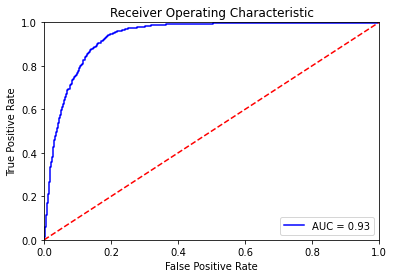

In [7]:
# Plot ROC of the best model

y_prob = classifier.predict_proba(X_test)[:,1]   
fpr, tpr, threshold = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

Logistic Regression has good ROC AUC value, but the recall is relatively low.